<font size = 5 color = yellow> <bb> NLP-powered sentiment analysis system that classifies reviews as +ve,neutral or -ve.

In [2]:
"""!pip install nltk==3.8.1
!pip install spacy==3.5.1
!pip install string
!pip install transformers torch"""
import torch
import nltk
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output

In [3]:
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [36]:
import spacy
from string import punctuation
import numpy as np
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from tensorflow import keras
from tensorflow.keras.layers import SpatialDropout1D, Embedding, LSTM, Dense
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

<font size = 5 color = Magenta> <b> Task 1: Data Collection & preprocessing

In [5]:
import pandas as pd
nlpData = pd.read_csv("/content/sample_data/bike_rental_reviews.csv")

In [6]:
def nlpDataSetInfo():
  print(f"INFO: {nlpData.info()}")
  print("========================================================\n")
  print(f"{nlpData.head()}")
  print("========================================================\n")
  print(f"columns : {nlpData.columns}")

In [7]:
nlpDataSetInfo()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  50000 non-null  object
 1   sentiment    50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
INFO: None

                                         review_text sentiment
0  The entire process was easy, and the availabil...  positive
1  Standard rental process. The mobile app was ac...   neutral
2  One of the best bike rentals I’ve had. The mob...  positive
3  One of the best bike rentals I’ve had. The cus...  positive
4  Not worth the money. The seat comfort was a ma...  negative

columns : Index(['review_text', 'sentiment'], dtype='object')


<font size = 5 color = orange> <b> Text cleaning function


In [8]:
# pos tag mapping
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
def clean_text(text):
  text = text.lower()   #lowering case
  text = ''.join([char for char in text if char not in punctuation])  #Punctuation removal
  # Obtain the list of stopwords from the corpus
  stp_wrds_eng = stopwords.words('english')
  text = ' '.join([word for word in text.split() if word not in stp_wrds_eng])  #Stopwords removal
  #Lemmatization
  # Get the pos tag
  tagged = nltk.pos_tag(text.split())
  # Create lemmatizer object
  lemmatizer = WordNetLemmatizer()
  lemma_sent = []
  for word, tag in tagged:
    new_tag = pos_tagger(tag)
    lemma = lemmatizer.lemmatize(word, new_tag)
    lemma_sent.append(lemma)
  text = ' '.join(lemma_sent)
  return lemma_sent


<font size = 3 color = orange> Tokenize and vectorize the text

In [10]:
from sklearn.preprocessing import LabelEncoder

nlpData['cleaned_review_text'] = nlpData['review_text'].apply(clean_text)

#Encode emotion labels into numbers
label_encoder = LabelEncoder()
nlpData['label'] = label_encoder.fit_transform(nlpData['sentiment'])

In [11]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned review text
X = vectorizer.fit_transform(nlpData['cleaned_review_text'].astype(str))
## Split data
y = nlpData['label']
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=42)


# Display the first few rows of the updated DataFrame and the feature matrix
display(nlpData.head())

,review_text,sentiment,cleaned_review_text,label
0,"The entire process was easy, and the availabil...",positive,"[entire, process, easy, availability, high, qu...",2
1,Standard rental process. The mobile app was ac...,neutral,"[standard, rental, process, mobile, app, accep...",1
2,One of the best bike rentals I’ve had. The mob...,positive,"[one, best, bike, rental, i’ve, mobile, app, m...",2
3,One of the best bike rentals I’ve had. The cus...,positive,"[one, best, bike, rental, i’ve, customer, serv...",2
4,Not worth the money. The seat comfort was a ma...,negative,"[worth, money, seat, comfort, major, letdown]",0


<Axes: >

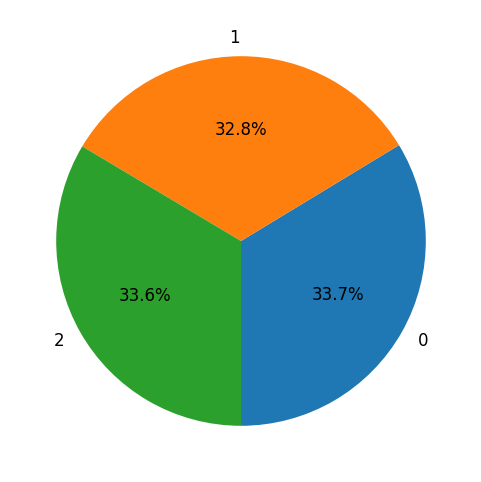

In [12]:
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
nlpData.groupby(['label']).size().plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

Summary:

Data Analysis Key Findings

*   A custom function `clean_text` was created to preprocess text data by converting to lowercase, removing punctuation and stopwords, and lemmatizing words using WordNet.
*   The `clean_text` function was successfully applied to the `review_text` column of the `nlpData` DataFrame.
*   A new column named `cleaned_review_text` was added to the `nlpData` DataFrame containing the processed text data.

Insights or Next Steps

*   The `cleaned_review_text` column is now ready for sentiment analysis modeling.


<font size = 5 color = Magenta> <b> # Task 2: Sentiment analysis:  
<font size = 3 color = orange> sentiment classification model (positive, neutral, negative)

# Logistic Regression

In [13]:
#Evaluate

def evaluate_model(y_pred, y_test,y):

  #Classification report
  print(classification_report(y_test, y_pred))

  #accuracy
  accuracy=accuracy_score(y_test,y_pred)
  print("accuracy",accuracy)

  #confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())
  disp.plot(cmap=plt.cm.Greens)
  disp.ax_.set_title("prediction on test data")


In [14]:
# Train Logistic Regression model
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

Evalution of Logistic Regression model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3325
           1       1.00      1.00      1.00      3317
           2       1.00      1.00      1.00      3358

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

accuracy 1.0


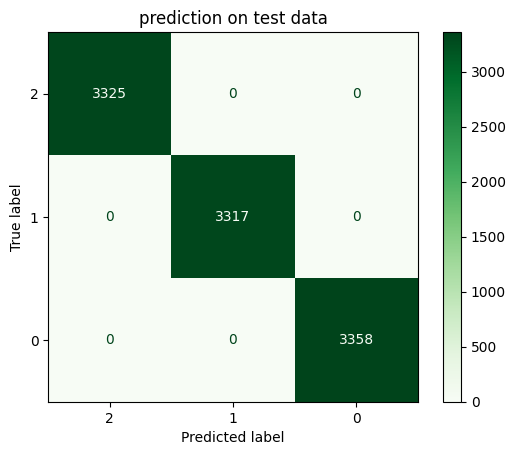

In [15]:
y_pred = model_lr.predict(X_test)
evaluate_model(y_pred,y_test,y)

# Naïve Bayes

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3325
           1       1.00      1.00      1.00      3317
           2       1.00      1.00      1.00      3358

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

accuracy 1.0


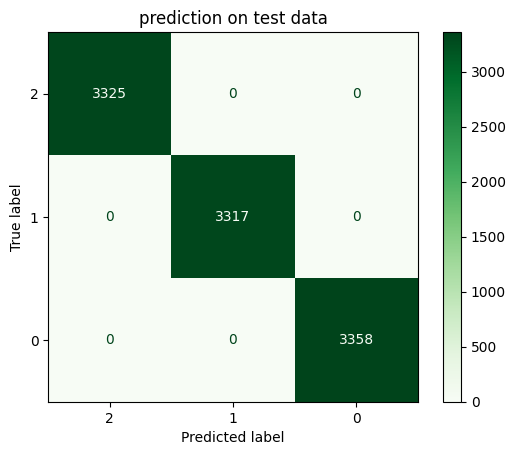

In [16]:
# Train a Multinomial Naive Bayes classifier
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

# Evaluate the Naive Bayes model
y_pred = model_nb.predict(X_test)
evaluate_model(y_pred,y_test,y)

# Deep learning models: LSTMs short for Long Short Term Memory

In [17]:
# Tokenize and Padding sequences
def tokenizePadLstm():
  tokenizer = Tokenizer(num_words=10000, oov_token="<unk>")

  # Tokenize the data
  tokenizer.fit_on_texts(nlpData['cleaned_review_text'])
  sequences = tokenizer.texts_to_sequences(nlpData['cleaned_review_text'])

  # Padding sequences
  X_padded = pad_sequences(sequences,padding='post')
  return X_padded

In [18]:
X_padded = tokenizePadLstm()
# Train-Test Split padded equal length data
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(X_padded, y.to_numpy(), test_size=0.33, random_state=42)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
# Model Building

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop if no improvement for 10 epochs
    min_delta=0.001,     # Minimum change to be considered an improvement
    verbose=1,           # Display messages
    mode='min',          # Monitor for decreasing validation loss
    restore_best_weights=True # Restore best weights found during training
)


embedding_dim = 128
lstm_units = 196
max_features = 500
model_lstm = keras.Sequential()
model_lstm.add(layers.Input(shape=(784,)))
model_lstm.add(Embedding(max_features, embedding_dim, input_length = X_padded.shape[1]))
model_lstm.add(SpatialDropout1D(0.4))
model_lstm.add(LSTM(lstm_units, dropout=0.33, recurrent_dropout=0.33))
model_lstm.add(layers.Dense(len(y.unique()), activation='softmax'))

print(model_lstm.summary())

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 784, 128)       │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 784, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 196)            │       254,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,391 (1.22 MB)

 Trainable params: 319,391 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
model_lstm.fit(x_train_p, y_train_p, epochs=10, batch_size=128, validation_data=(x_test_p, y_test_p), callbacks=[early_stopping],verbose = 2) # batch_size = Number of sample sequences to pass through (and aggregate the error) before backpropagating

Epoch 1/10
262/262 - 18s - 70ms/step - accuracy: 0.9742 - loss: 0.0747 - val_accuracy: 1.0000 - val_loss: 4.5788e-06
Epoch 2/10
262/262 - 11s - 41ms/step - accuracy: 0.9999 - loss: 5.5039e-04 - val_accuracy: 1.0000 - val_loss: 1.2901e-05
Epoch 3/10
262/262 - 10s - 39ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 2.0456e-05
Epoch 4/10
262/262 - 11s - 43ms/step - accuracy: 1.0000 - loss: 1.8010e-05 - val_accuracy: 1.0000 - val_loss: 8.3173e-06
Epoch 5/10
262/262 - 20s - 75ms/step - accuracy: 1.0000 - loss: 9.0452e-06 - val_accuracy: 1.0000 - val_loss: 5.0719e-06
Epoch 6/10
262/262 - 11s - 42ms/step - accuracy: 1.0000 - loss: 5.9488e-06 - val_accuracy: 1.0000 - val_loss: 3.5334e-06
Epoch 7/10
262/262 - 11s - 42ms/step - accuracy: 1.0000 - loss: 3.5242e-04 - val_accuracy: 1.0000 - val_loss: 4.8825e-06
Epoch 8/10
262/262 - 11s - 43ms/step - accuracy: 1.0000 - loss: 4.8014e-06 - val_accuracy: 1.0000 - val_loss: 2.8540e-06
Epoch 9/10
262/262 - 11s - 40ms/step - a

In [21]:
# Evaluate the LSTM model
loss, accuracy = model_lstm.evaluate(x_test_p, y_test_p,verbose = 1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Calculate precision, recall, F1 score
y_pred_p = model_lstm.predict(x_test_p)


print('Precision:', precision_score(y_test_p, np.argmax(y_pred_p, axis=1), average='weighted'))
print('Recall:', recall_score(y_test_p, np.argmax(y_pred_p, axis=1), average='weighted'))
print('F1 score:', f1_score(y_test_p, np.argmax(y_pred_p, axis=1), average='weighted'))

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 1.0000 - loss: 4.5871e-06
Test Loss: 0.0000, Test Accuracy: 1.0000
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Precision: 1.0
Recall: 1.0
F1 score: 1.0


# Transformers (BERT): Bidirectional Representation for Transformers

In [26]:
nlpData['cleaned_review_text_str'] = nlpData['cleaned_review_text'].apply(lambda x: ' '.join(x))
nlpData_bert = nlpData[['cleaned_review_text_str','label']]
nlpData_bert

,cleaned_review_text_str,label
0,entire process easy availability high quality,2
1,standard rental process mobile app acceptable,1
2,one best bike rental i’ve mobile app make even...,2
3,one best bike rental i’ve customer service mak...,2
4,worth money seat comfort major letdown,0
...,...,...
49995,bike terrible condition mobile app nightmare,0
49996,standard rental process availability acceptable,1
49997,absolutely love mobile app experience fantastic,2
49998,worth money rental station major letdown,0


In [46]:
X_bert = nlpData_bert.cleaned_review_text_str
y_bert = nlpData_bert.label
X_train,X_test,y_train,y_test = train_test_split(X_bert,
                                                y_bert,
                                                test_size = 0.15,
                                                random_state=17,
                                                stratify = y)

In [47]:
#Create a CustomDataset Class
class CustomDataset():
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [48]:
#Initialize the BERT Model and Tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(nlpData_bert.label.unique()))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
train_text, val_text, train_labels, val_labels = train_test_split(nlpData_bert['cleaned_review_text_str'], nlpData_bert['label'], random_state=42, test_size=0.2, stratify=nlpData_bert['label'])

In [50]:
#Create DataLoaders
batch_size = 8
max_len = 64 # Reduce max_len for faster processing

train_dataset = CustomDataset(train_text.reset_index(drop=True), train_labels.reset_index(drop=True), tokenizer, max_len)
val_dataset = CustomDataset(val_text.reset_index(drop=True), val_labels.reset_index(drop=True), tokenizer, max_len)


train_sampler = RandomSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)

In [51]:
#Set Up Training Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Training Loop
num_epochs = 3
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    total_loss = 0
    predictions = []
    labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            batch_pred = torch.argmax(logits, dim=1)
            predictions.extend(batch_pred.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    epoch_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(labels, predictions)
    print(f'Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {accuracy:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

In [44]:
#Evaluation
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        batch_pred = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().tolist())
        y_pred.extend(batch_pred.cpu().tolist())

print(classification_report(y_true, y_pred))

KeyError: 0